In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/ASD_Circuits/src')
from ASD_Circuits import *
from tabulate import tabulate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
graph = LoadConnectome2()
graph_local = LoadConnectome2("../dat/allen-mouse-conn/adj_mat_cartesian_local.csv")
graph_distal = LoadConnectome2("../dat/allen-mouse-conn/adj_mat_cartesian_distal.csv")
EdgeWeightsDict = EdgeDict(graph)
str2reg, reg2str = LoadSTR2REG()
adj_mat = pd.read_csv(ConnFil, index_col=0)
adj_region_local, adj_region_distal = ConnectomeSeperation_Region(adj_mat, str2reg)
graph_region_local = LoadConnectome2(adj_region_local)
graph_region_distal = LoadConnectome2(adj_region_distal)

In [5]:
def LoadSA(fname, DIR):
    fin = open(DIR+fname, 'rt')
    max_cohe, max_bias, max_STRs = 0, 0, []
    for l in fin:
        l = l.strip().split()
        cohe = float(l[0])
        bias = float(l[1])
        STRs = l[2].split(",")
        if cohe > max_cohe:
            max_cohe = cohe
            max_bias = bias
            max_STRs = STRs
    return max_cohe, max_bias, max_STRs
def GetData(params, size, DIR):
    tmp_parames = params[params["Size"]==size]
    COHES, CutBias, RealBias, STRS = [],[],[],[]
    for i, row in tmp_parames.iterrows():
        #print(row["fname"], DIR)
        try:
            cohe, real_minbias, STRs = LoadSA(row["fname"], DIR)
        except:
            print("Missing Data: {}".format(row))
            continue
        if cohe == 0:
            continue
        COHES.append(cohe)
        CutBias.append(row["minBias"])
        RealBias.append(real_minbias)
        STRS.append(STRs)
        #print(i, cohe, real_minbias)
    return COHES, CutBias, RealBias, STRS
def normtoUnit(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)
def searchFil(text, DIR):
    RES = []
    for file in os.listdir(DIR):
        if text in file:
            RES.append(file)
    return RES
class BiasCohePareto:
    def __init__(self, biasDF, Array, Dir):
        self.BiasDF = biasDF
        self.params = pd.read_csv(Array, index_col=0, header=None)
        self.params.columns = ["Size", "minBias"]
        self.DIR = Dir
        for i, row in self.params.iterrows():
            for file in os.listdir(self.DIR):
                if file.startswith("SA.{}.".format(i)):
                    self.params.loc[i, "fname"] = file
        All_Sizes = []
        All_Cohes = []
        All_Local_Cohes = []
        All_Distal_Cohes = []
        All_SR_Cohes = []
        All_CR_Cohes = []
        All_CutBias = []
        All_RealBias = []
        All_Index = []
        for size in set(self.params["Size"].values):
            if size > 121:
                continue
            COHES, CutBias, RealBias, STRS = GetData(self.params, size, self.DIR)
            cohe_1 = [ScoreSTRSet(graph_local, STRs, EdgeWeightsDict, Weighted=True)[0]
                     for STRs in STRS]
            cohe_2 = [ScoreSTRSet(graph_distal, STRs, EdgeWeightsDict, Weighted=True)[0]
                     for STRs in STRS]
            cohe_3 = [ScoreSTRSet(graph_region_local, STRs, EdgeWeightsDict, Weighted=True)[0]
                     for STRs in STRS]
            cohe_4 = [ScoreSTRSet(graph_region_distal, STRs, EdgeWeightsDict, Weighted=True)[0]
                     for STRs in STRS]
            All_Sizes.extend([size]*len(COHES))
            All_Cohes.extend(COHES)
            All_Local_Cohes.extend(cohe_1)
            All_Distal_Cohes.extend(cohe_2)
            All_SR_Cohes.extend(cohe_3)
            All_CR_Cohes.extend(cohe_4)
            All_CutBias.extend(CutBias)
            All_RealBias.extend(RealBias)
        self.DF = pd.DataFrame(data={"Size":All_Sizes, "Cohe":All_Cohes, 
                "Cohe_Local": All_Local_Cohes, "Cohe_Distal": All_Distal_Cohes, 
                "Cohe_SR": All_SR_Cohes, "Cohe_CR": All_CR_Cohes, 
                "CutBias":All_CutBias, "Bias":All_RealBias})
        
    def paretoFrontLine(self, EdgeWeightsDict):
        min_bias = np.min(self.DF["Bias"].values)
        max_bias = np.max(self.DF["Bias"].values)
        #print(min_bias, max_bias)
        Biases = np.arange(min_bias, max_bias, 0.005)

        Front_biases = []
        Front_cut_biases = []
        Front_cohes = []
        Front_sizes = []
        Front_indice = []
        for bias in Biases:
            tmp_df = self.DF[self.DF["Bias"]>bias]
            xx = tmp_df[tmp_df.Cohe == tmp_df.Cohe.max()]
            if xx.index[0] not in Front_indice:
                Front_indice.append(xx.index[0])
                Front_biases.append(xx["Bias"].values[0])
                Front_cohes.append(xx["Cohe"].values[0])
                Front_sizes.append(xx["Size"].values[0])
                Front_cut_biases.append(xx["CutBias"].values[0])

        dat = []
        for i, (cutb, size) in enumerate(zip(Front_cut_biases, Front_sizes)):
            search_text = "keepN_{}-minbias_{}.".format(size, cutb)
            f = searchFil(search_text, self.DIR)[0]
            cohe, real_minbias, STRs = LoadSA(f, self.DIR)
            cohe_local = ScoreSTRSet(graph_local, STRs, EdgeWeightsDict, Weighted=True)[0]
            cohe_distal = ScoreSTRSet(graph_distal, STRs, EdgeWeightsDict, Weighted=True)[0]
            # graph_region_local
            cohe_sr = ScoreSTRSet(graph_region_local, STRs, EdgeWeightsDict, Weighted=True)[0]
            cohe_cr = ScoreSTRSet(graph_region_distal, STRs, EdgeWeightsDict, Weighted=True)[0]
            dat.append([size, cohe, cohe_local, cohe_distal, cohe_sr, cohe_cr,
                        real_minbias, RegionDistributionsList(STRs)])
        self.FrontDF = pd.DataFrame(data=dat, columns=["Size", "Cohe", 
                                "Cohe_local", "Cohe_Distal", "Cohe_SR", 
                                "Cohe_CR","Bias", "STRs"])
        
    def plotFront(self):
        fig, ax = plt.subplots(dpi=480, figsize=(6,6))
        for size in set(self.params["Size"].values):
            COHES, CutBias, RealBias, STRS = GetData(self.params, size, self.DIR)
            line, = ax.plot(COHES, RealBias, 'o-')
            color = line.get_color()
            ax.plot(COHES, CutBias, 'x--', color=color) 
        Front_cohes = self.FrontDF["Cohe"]
        Front_biases = self.FrontDF["Bias"]
        ax.plot(Front_cohes, Front_biases, marker="o", color="black", zorder=100, 
                    label="Pareto Front Line")
        ax.legend()
        ax.set_xlabel("Cohesiveness")
        ax.set_ylabel("Mean Bias")
        #ax.set_ylim((0.25, 0.5))
        plt.grid(True)
        plt.show()
        

In [7]:
ASD_BiasDF = pd.read_csv("../dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.csv", index_col="STR")
ASD_Arr = "../dat/Circuits/SA/Array_size_biaslim.Around1.txt"
ASD_Dir = "../dat/Circuits/SA/ASD_Around1/"
ASD_Pareto = BiasCohePareto(ASD_BiasDF, ASD_Arr, ASD_Dir)
ASD_Pareto.paretoFrontLine(EdgeWeightsDict)

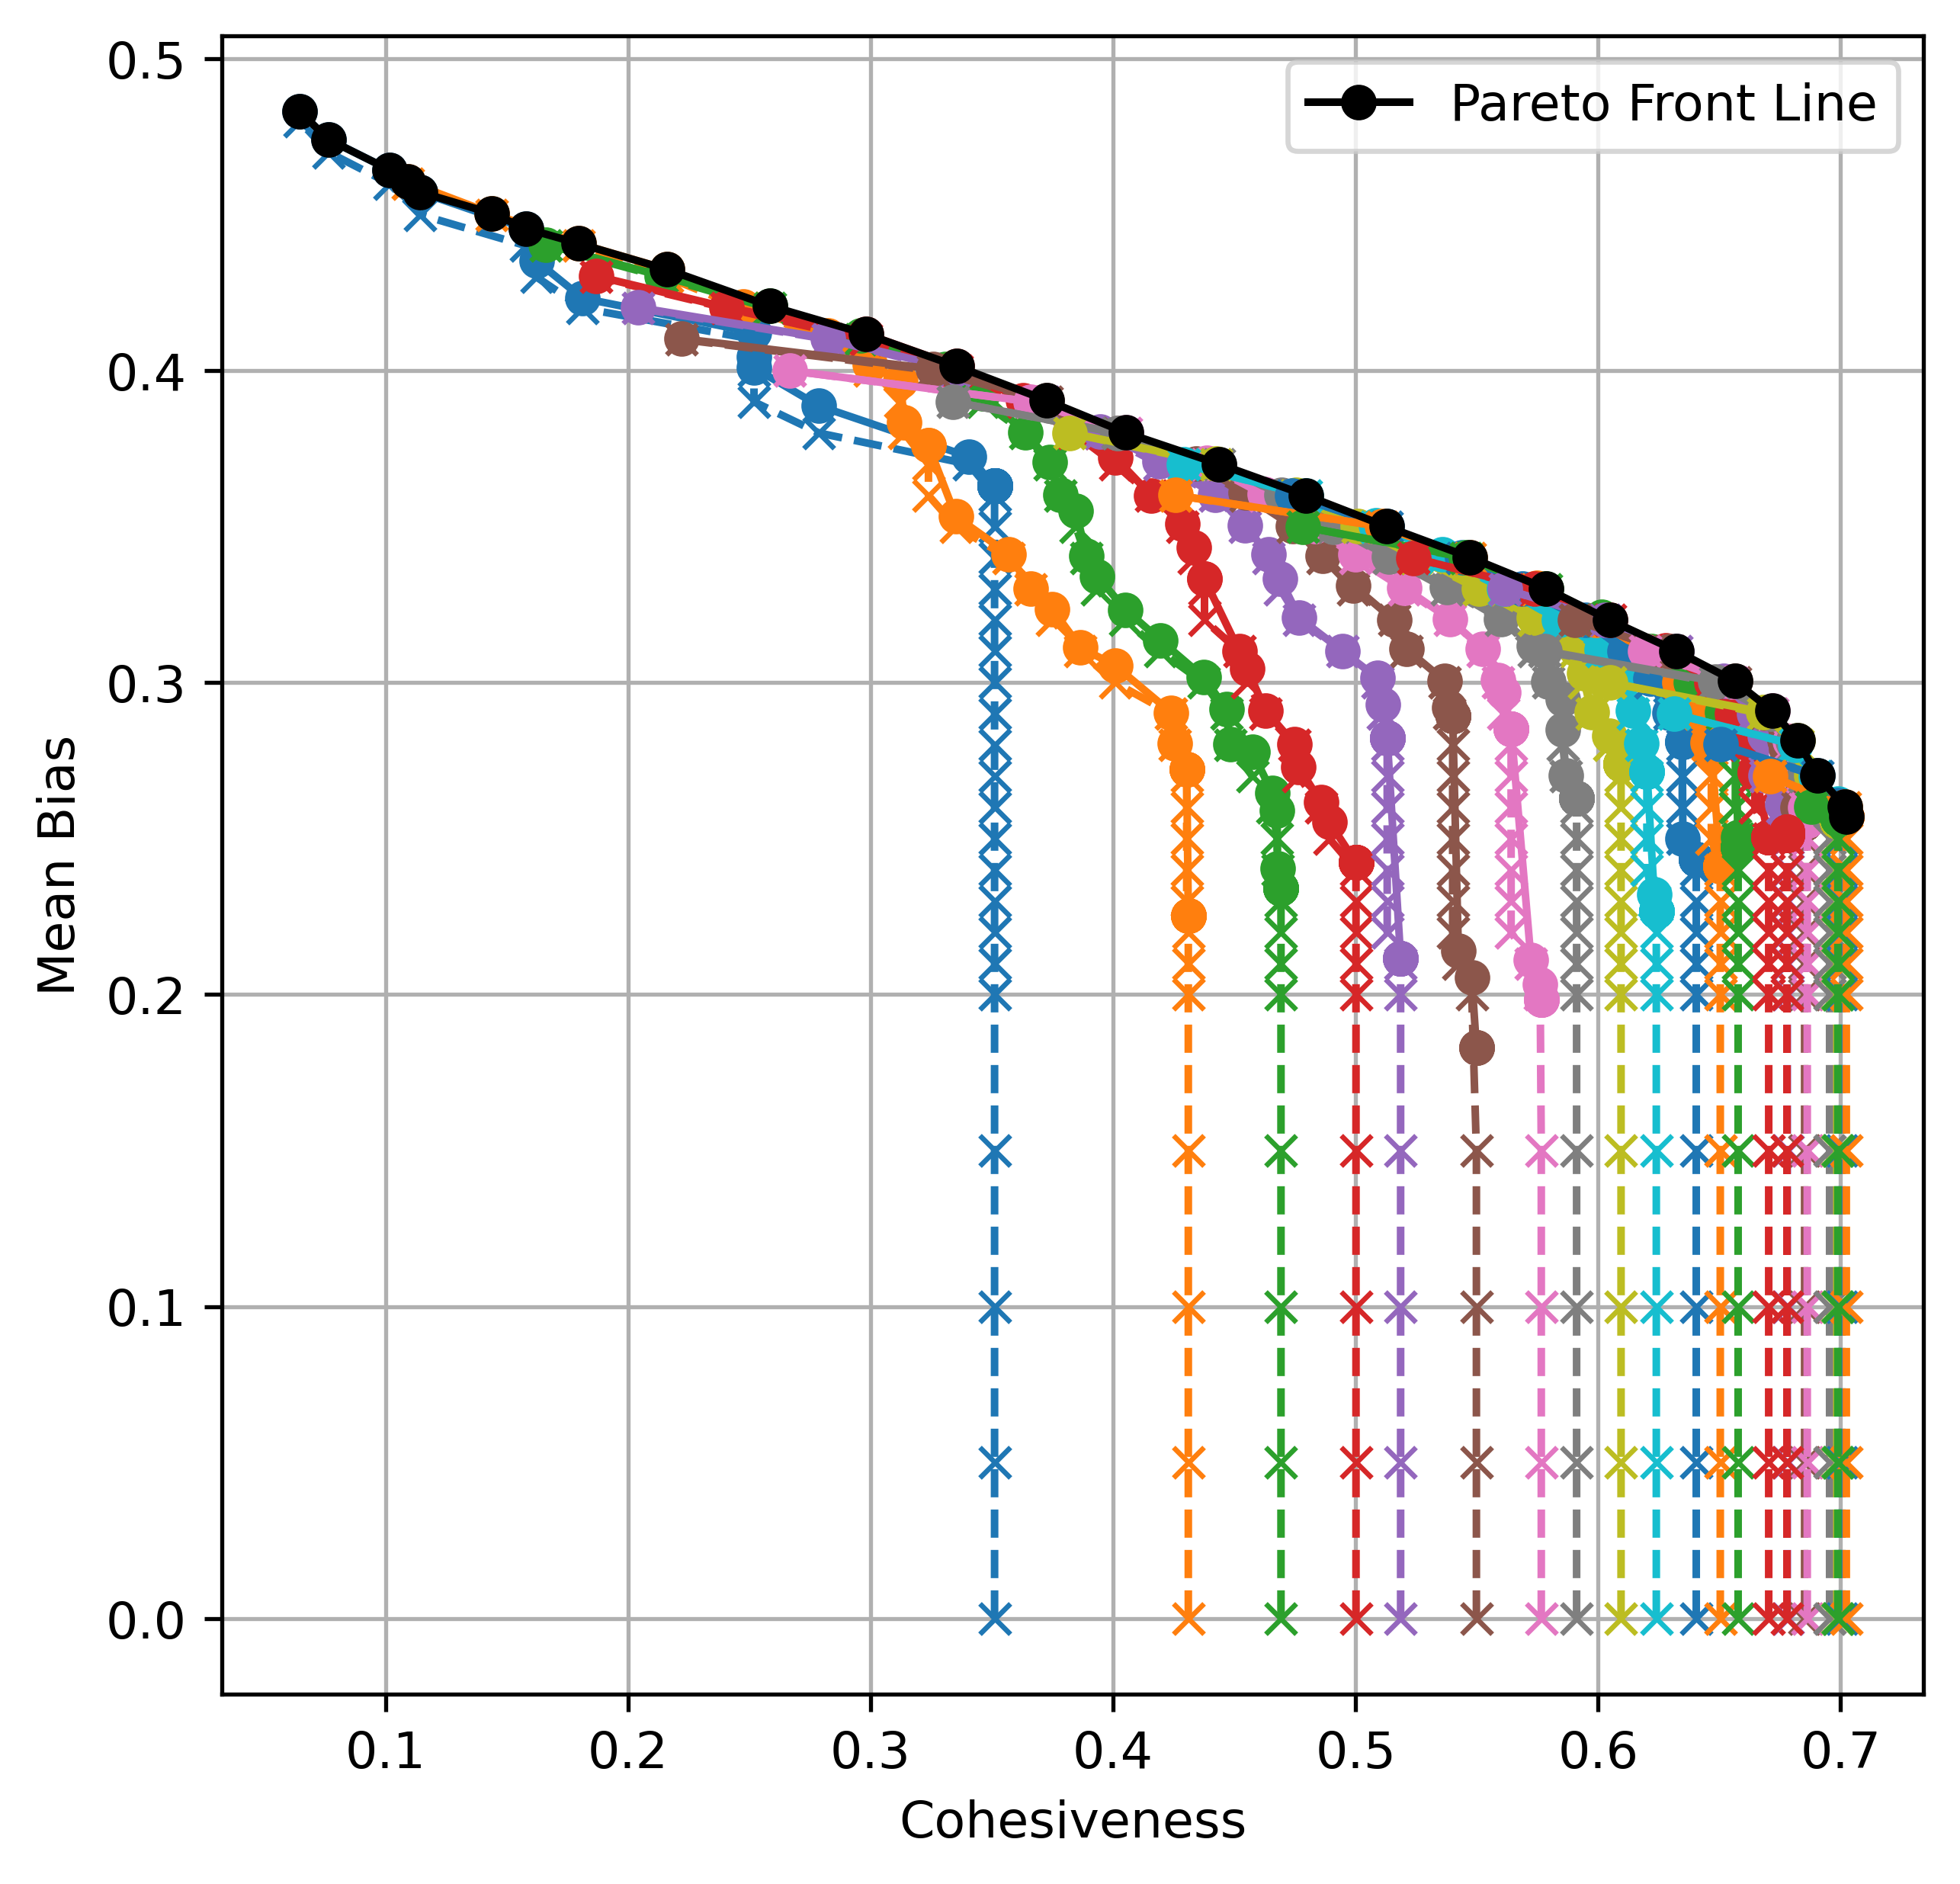

In [8]:
#plt.plot(ASD_Pareto.FrontDF["Cohe"], ASD_Pareto.FrontDF["Bias"], marker="o",
#         label="ASD", color="blue")
ASD_Pareto.plotFront()

In [12]:
ASD_Cont_Paretos = []
N_cont = 10
for i in range(1, 1+N_cont, 1):
    ASD_cont_BiasDF = pd.read_csv("../dat/Unionize_bias/ASD_Sim/cont.bias.1.{}.csv".format(i), 
                                  index_col="STR")
    #ASD_cont_Arr = "dat/SA/ASD_cont/Array.cont.bias.1.{}.csv".format(i)
    ASD_cont_Arr = ASD_Arr
    ASD_cont_Dir = "../dat/Circuits/SA/ASD_Cont/complete_search/dat_con.bias.1.{}/".format(i)
    ASD_cont_Pareto = BiasCohePareto(ASD_cont_BiasDF, ASD_cont_Arr, ASD_cont_Dir)
    ASD_cont_Pareto.paretoFrontLine(EdgeWeightsDict)
    ASD_Cont_Paretos.append(ASD_cont_Pareto)

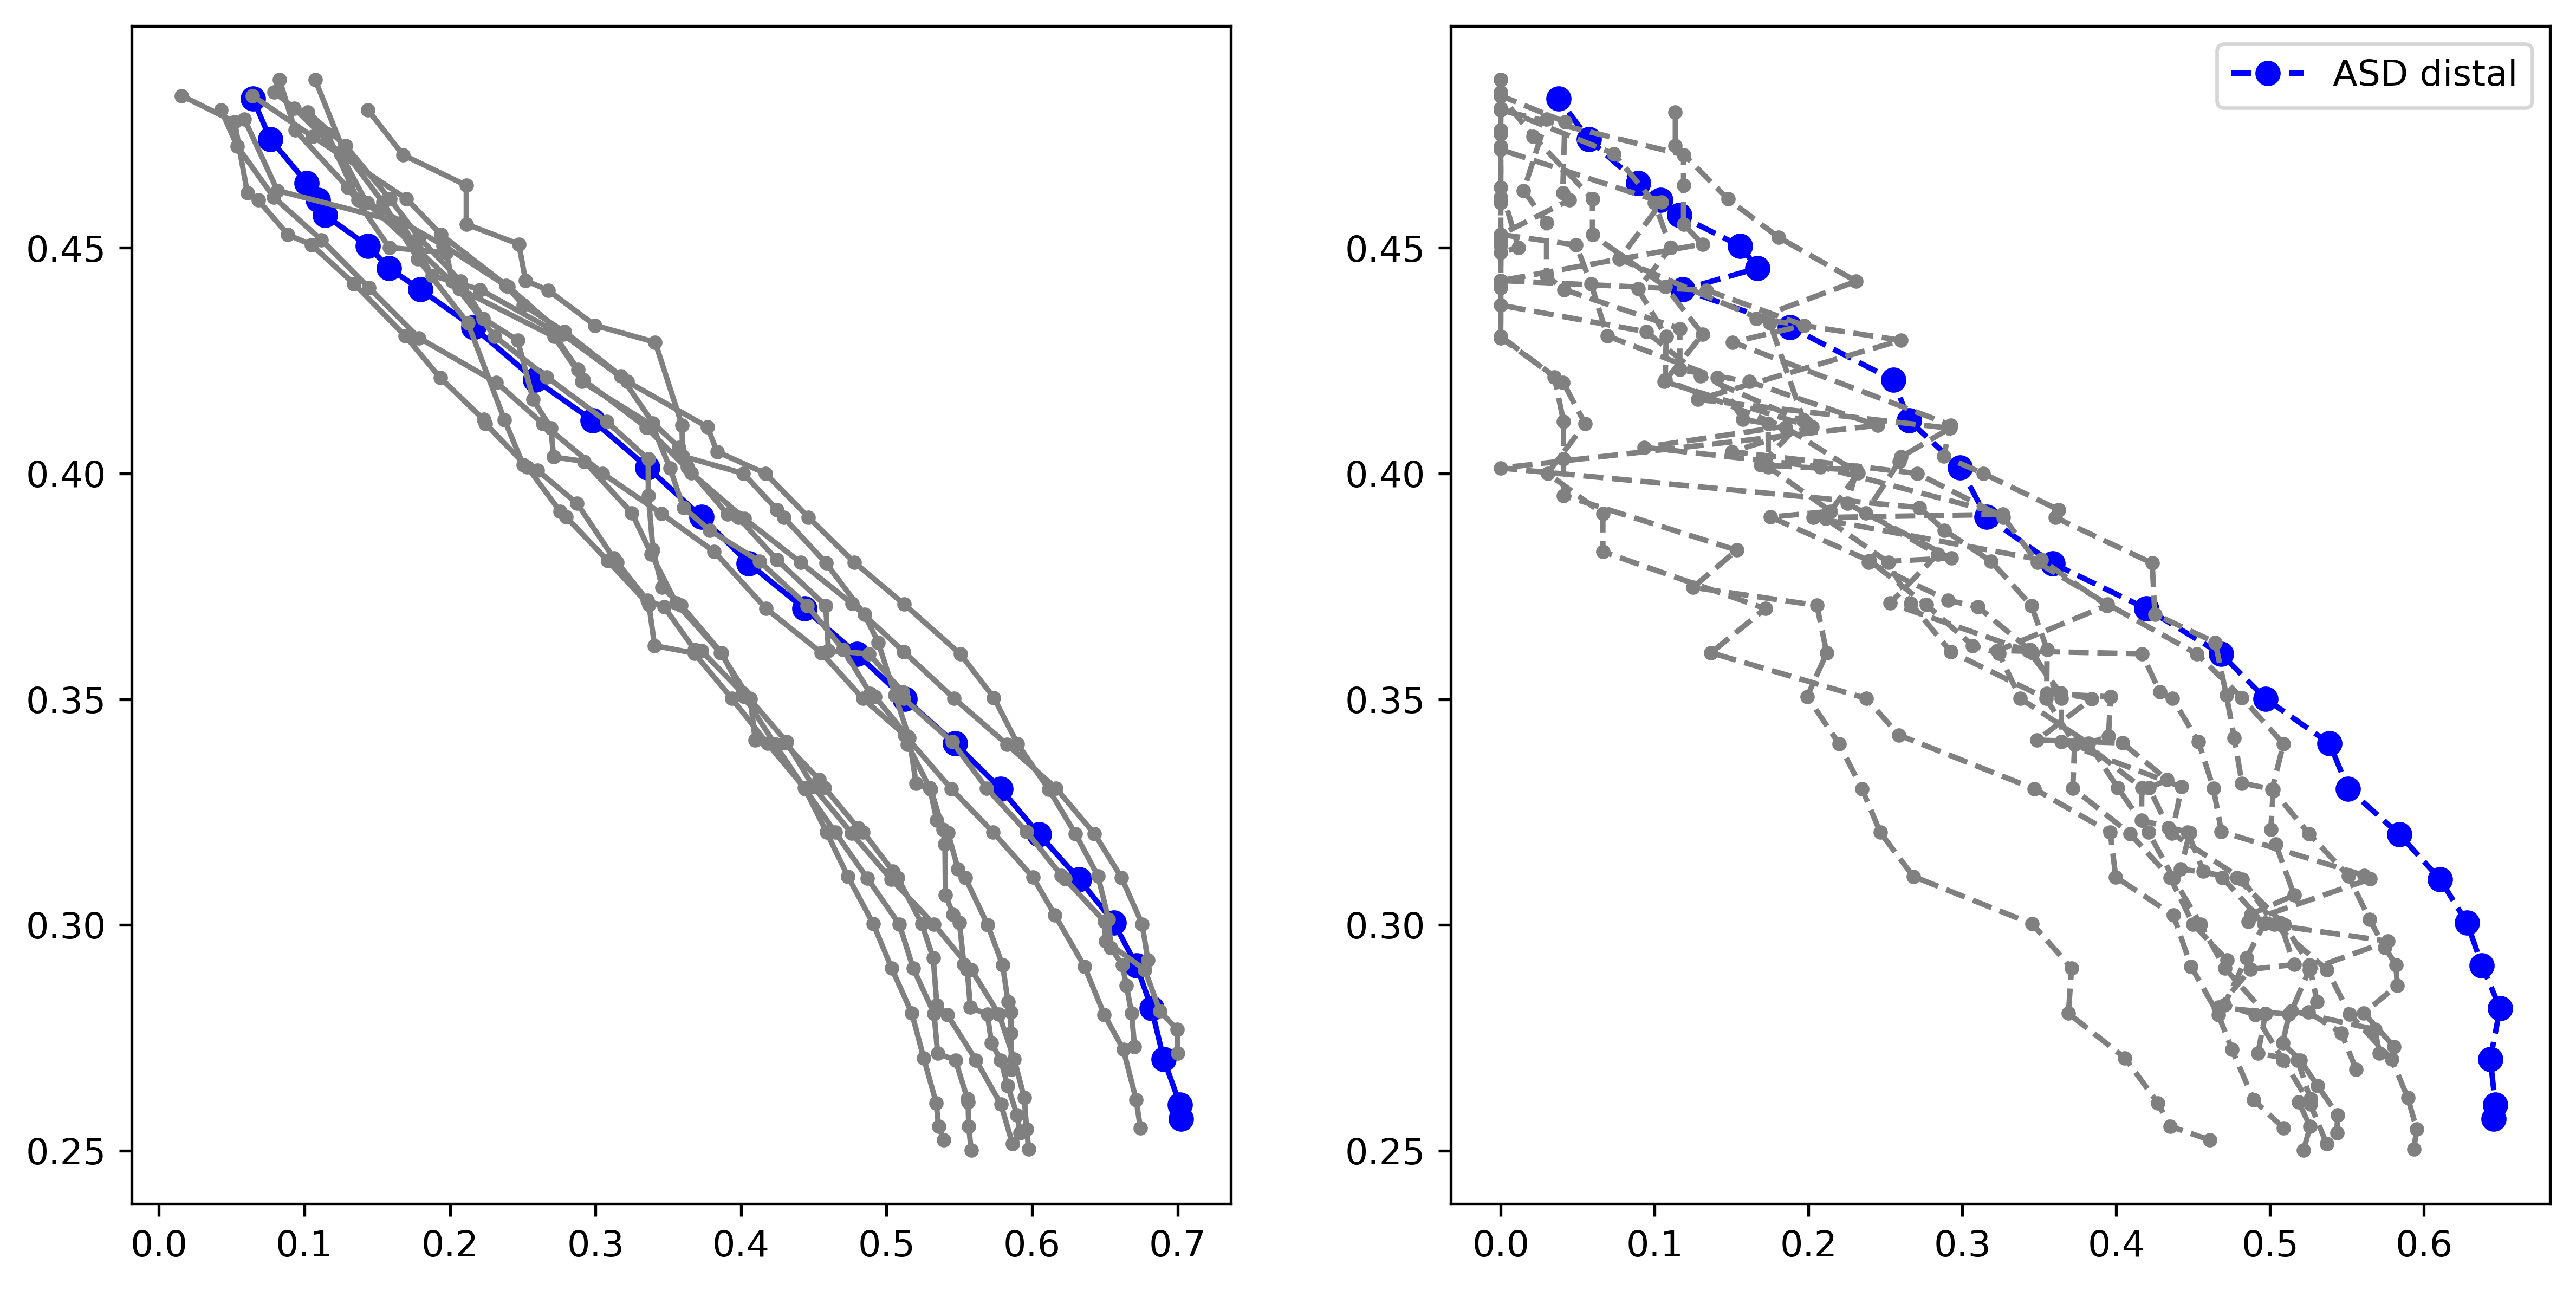

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=480, figsize=(12,6))
ax1.plot(ASD_Pareto.FrontDF["Cohe"], ASD_Pareto.FrontDF["Bias"], marker="o",
         label="ASD", color="blue")
ax2.plot(ASD_Pareto.FrontDF["Cohe_Distal"], ASD_Pareto.FrontDF["Bias"], marker="o",
         ls = '--', label="ASD distal", color="blue")


for i in range(1, 1+N_cont, 1):
    xx = ASD_Cont_Paretos[i-1]
    ax1.plot(xx.FrontDF["Cohe"], xx.FrontDF["Bias"], marker="o", markersize=3,
          color="grey")
    ax2.plot(xx.FrontDF["Cohe_Distal"], xx.FrontDF["Bias"], marker="o", markersize=3,
          ls = '--', color="grey")
plt.legend()
#plt.grid(True)
plt.savefig("../figs/ParetoFront.ASD.vs.Cont.pdf")

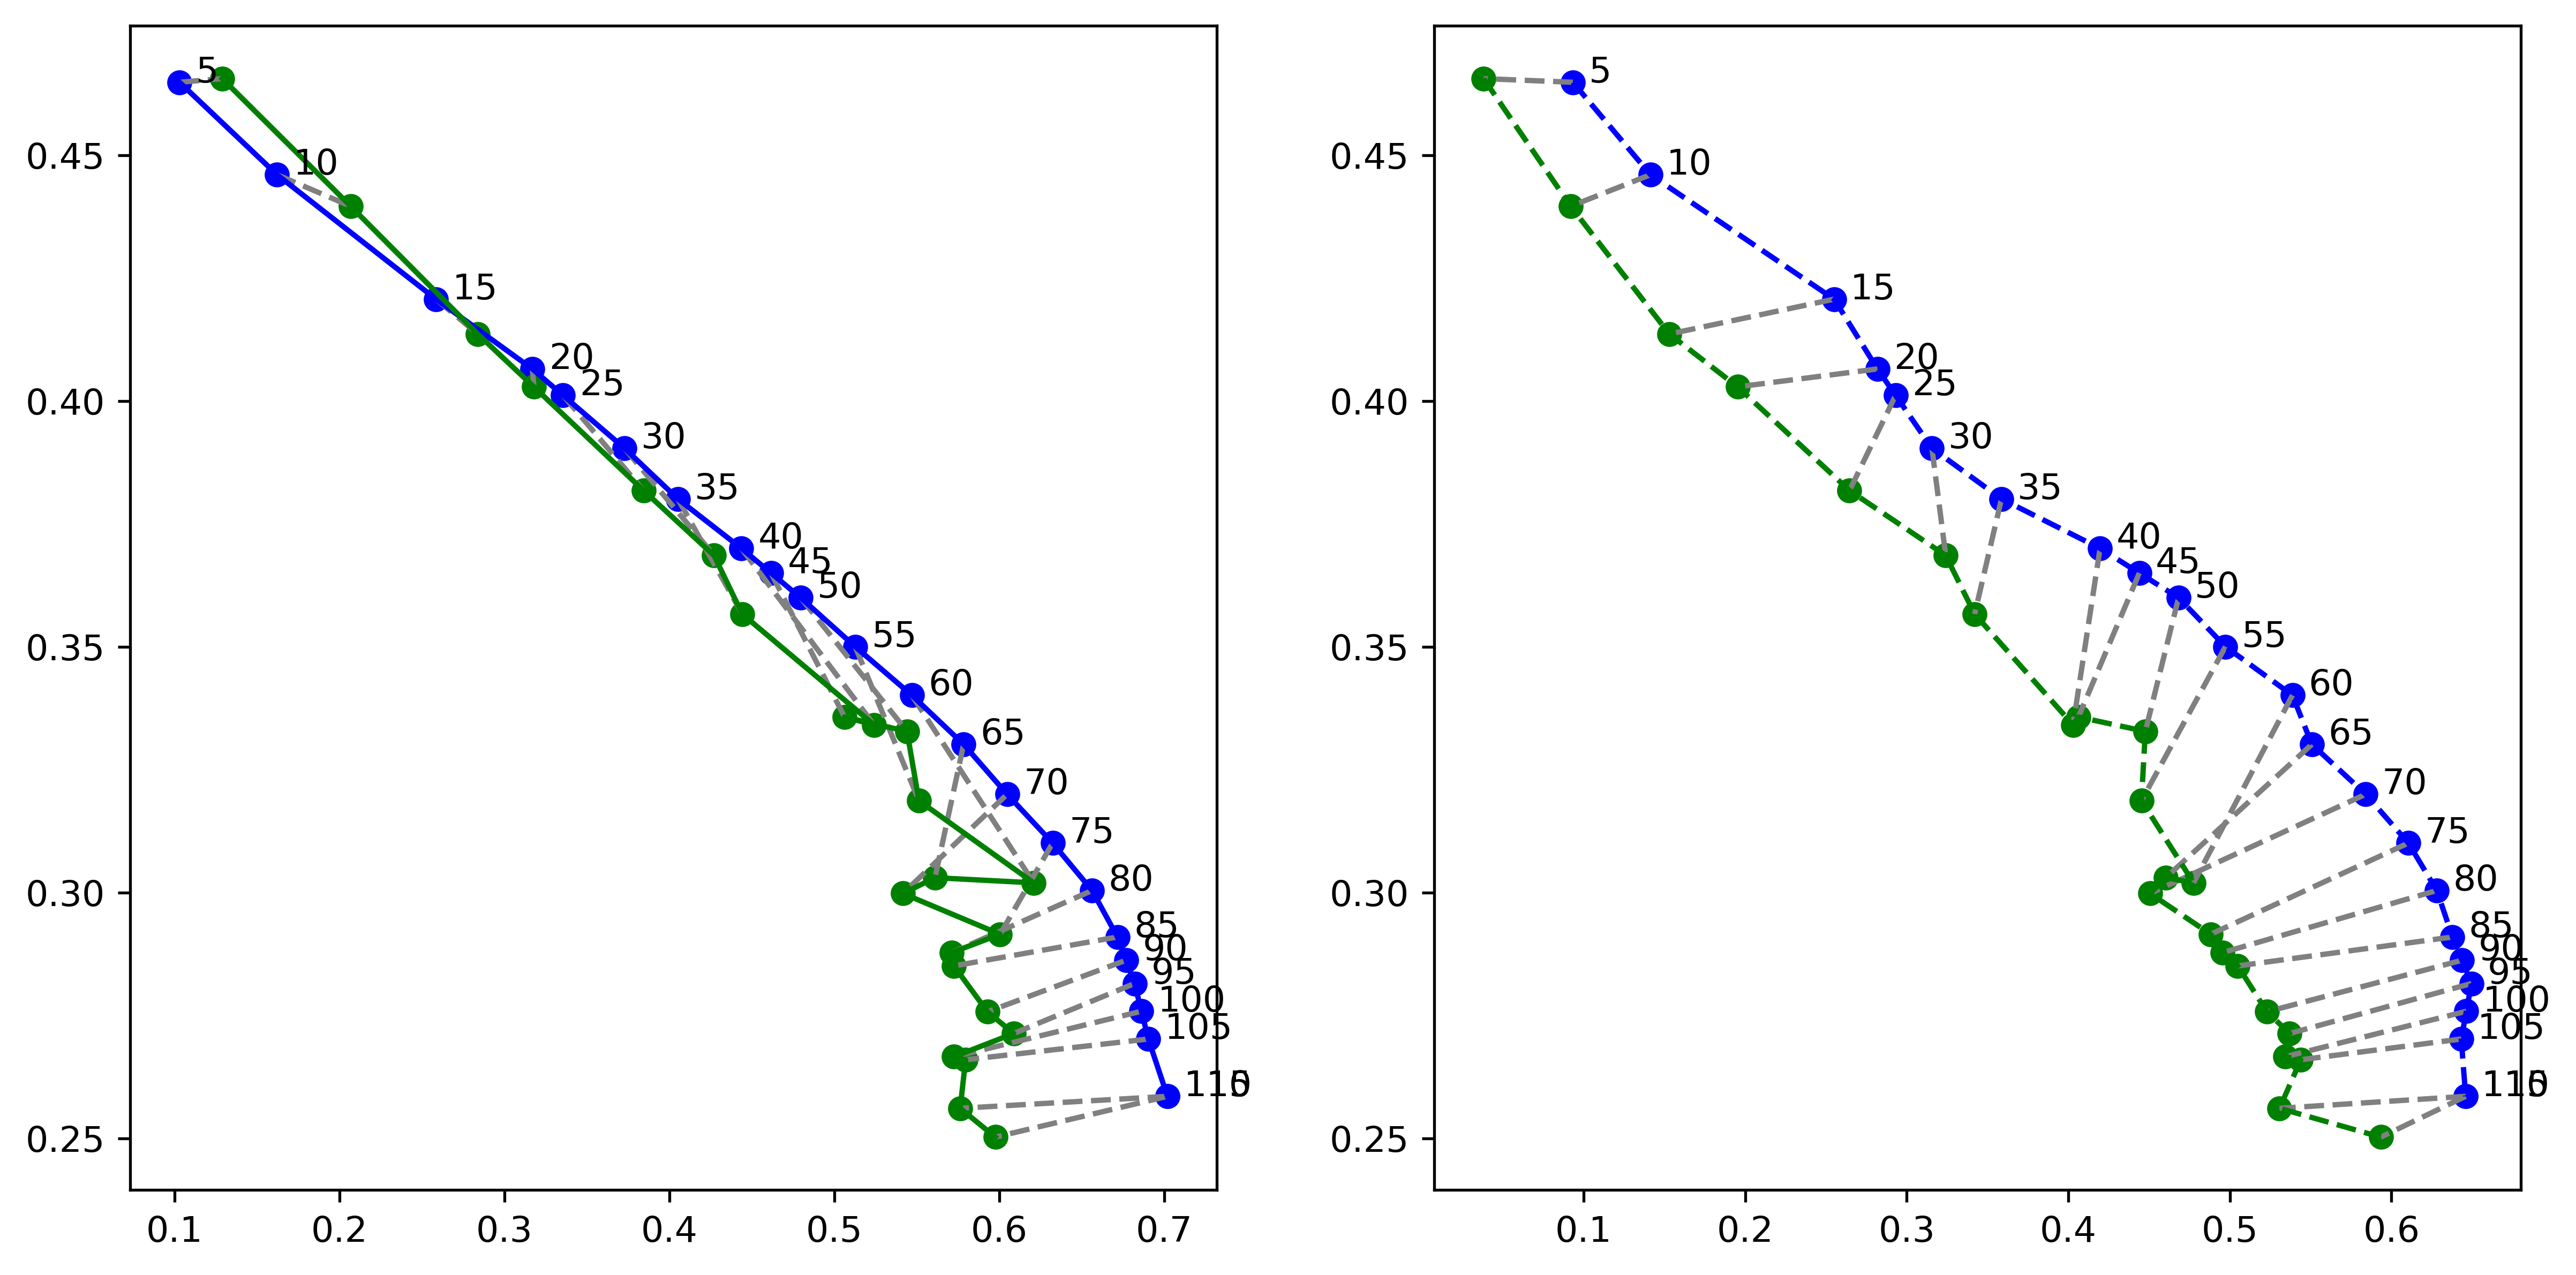

In [15]:
#Combine Sims
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=480, figsize=(12,6))
asd_line_x, asd_line_y = [], []
cont_line_x, cont_line_y = [], []
for size in np.arange(5, 120, 5):
    xx = ASD_Pareto.FrontDF[ASD_Pareto.FrontDF["Size"]==size]
    if len(xx) == 0:
        xx = ASD_Pareto.FrontDF[(ASD_Pareto.FrontDF["Size"]>=size-5) &
                                (ASD_Pareto.FrontDF["Size"]<=size+5)]
    asd_bias = xx["Bias"].mean()
    asd_cohe = xx["Cohe"].mean()
    ax1.annotate(text="{}".format(size), xy=(asd_cohe+0.01, asd_bias), )
    ax1.scatter(asd_cohe, asd_bias, color="blue")
    asd_line_x.append(asd_cohe)
    asd_line_y.append(asd_bias)
    cont_bias_avg = []
    cont_cohe_avg = []
    cont_cohe_distal_avg = []
    for i in range(1, 11, 1):
        xx = ASD_Cont_Paretos[i-1]
        xx = xx.FrontDF[xx.FrontDF["Size"]==size]
        bias = xx["Bias"].mean()
        cohe = xx["Cohe"].mean()
        cont_bias_avg.append(bias)
        cont_cohe_avg.append(cohe)
    xx_bias = np.nanmean(cont_bias_avg)
    xx_cohe = np.nanmean(cont_cohe_avg)
    ax1.scatter(xx_cohe, xx_bias, color="green")
    ax1.plot([asd_cohe, xx_cohe], [asd_bias, xx_bias], ls="--", color="grey")
    cont_line_x.append(xx_cohe)
    cont_line_y.append(xx_bias)
ax1.plot(asd_line_x, asd_line_y, color="blue", label="asd")
ax1.plot(cont_line_x, cont_line_y, color="green", label="cont")

asd_line_x, asd_line_y = [], []
cont_line_x, cont_line_y = [], []
for size in np.arange(5, 120, 5):
    xx = ASD_Pareto.FrontDF[ASD_Pareto.FrontDF["Size"]==size]
    if len(xx) == 0:
        xx = ASD_Pareto.FrontDF[(ASD_Pareto.FrontDF["Size"]>=size-5) &
                                (ASD_Pareto.FrontDF["Size"]<=size+5)]
    asd_bias = xx["Bias"].mean()
    asd_cohe = xx["Cohe_Distal"].mean()
    #asd_cohe = xx["Cohe_CR"].mean()
    ax2.annotate(text="{}".format(size), xy=(asd_cohe+0.01, asd_bias), )
    ax2.scatter(asd_cohe, asd_bias, color="blue")
    asd_line_x.append(asd_cohe)
    asd_line_y.append(asd_bias)
    cont_bias_avg = []
    cont_cohe_avg = []
    cont_cohe_distal_avg = []
    for i in range(1, 11, 1):
        xx = ASD_Cont_Paretos[i-1]
        xx = xx.FrontDF[xx.FrontDF["Size"]==size]
        bias = xx["Bias"].mean()
        cohe = xx["Cohe_Distal"].mean()
        #cohe = xx["Cohe_CR"].mean()
        cont_bias_avg.append(bias)
        cont_cohe_avg.append(cohe)
    xx_bias = np.nanmean(cont_bias_avg)
    xx_cohe = np.nanmean(cont_cohe_avg)
    ax2.scatter(xx_cohe, xx_bias, color="green")
    ax2.plot([asd_cohe, xx_cohe], [asd_bias, xx_bias], ls="--", color="grey")
    cont_line_x.append(xx_cohe)
    cont_line_y.append(xx_bias)
ax2.plot(asd_line_x, asd_line_y, color="blue", label="asd", ls="--")
ax2.plot(cont_line_x, cont_line_y, color="green", label="cont", ls="--")

#plt.savefig("figs/ParetoFront.ASD.vs.Cont.avg.pdf")

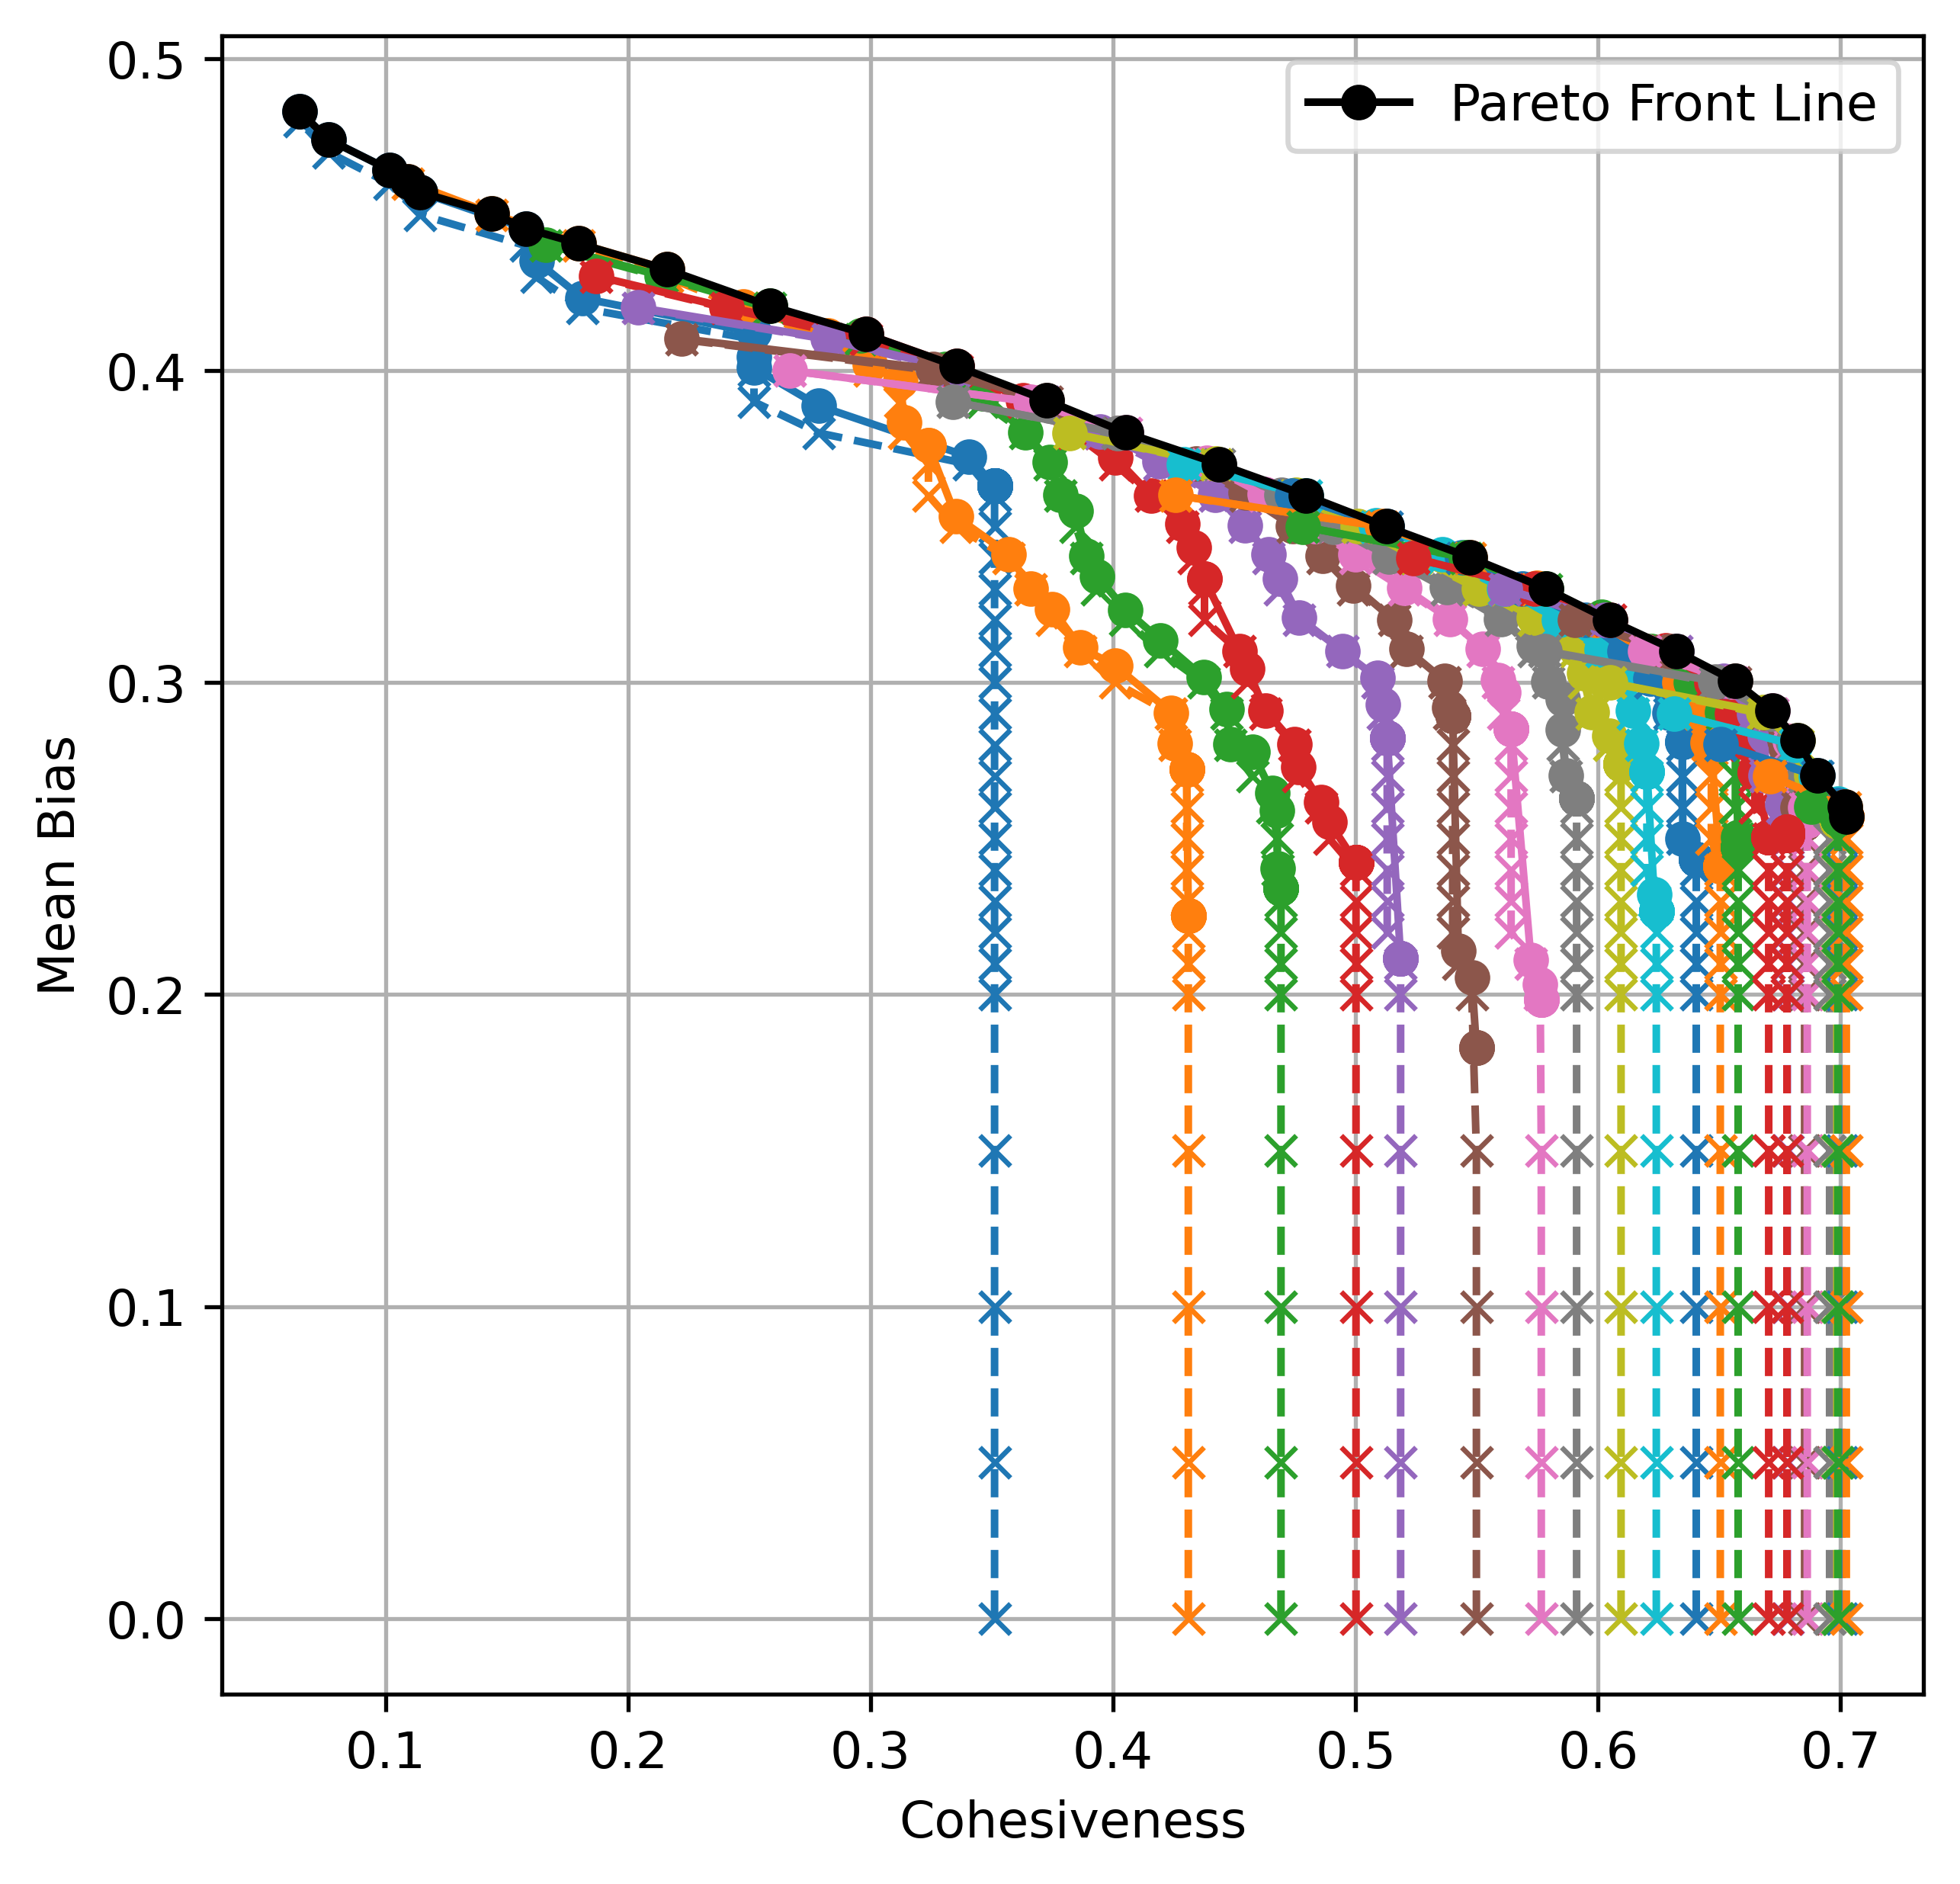

In [16]:
ASD_Pareto.plotFront()

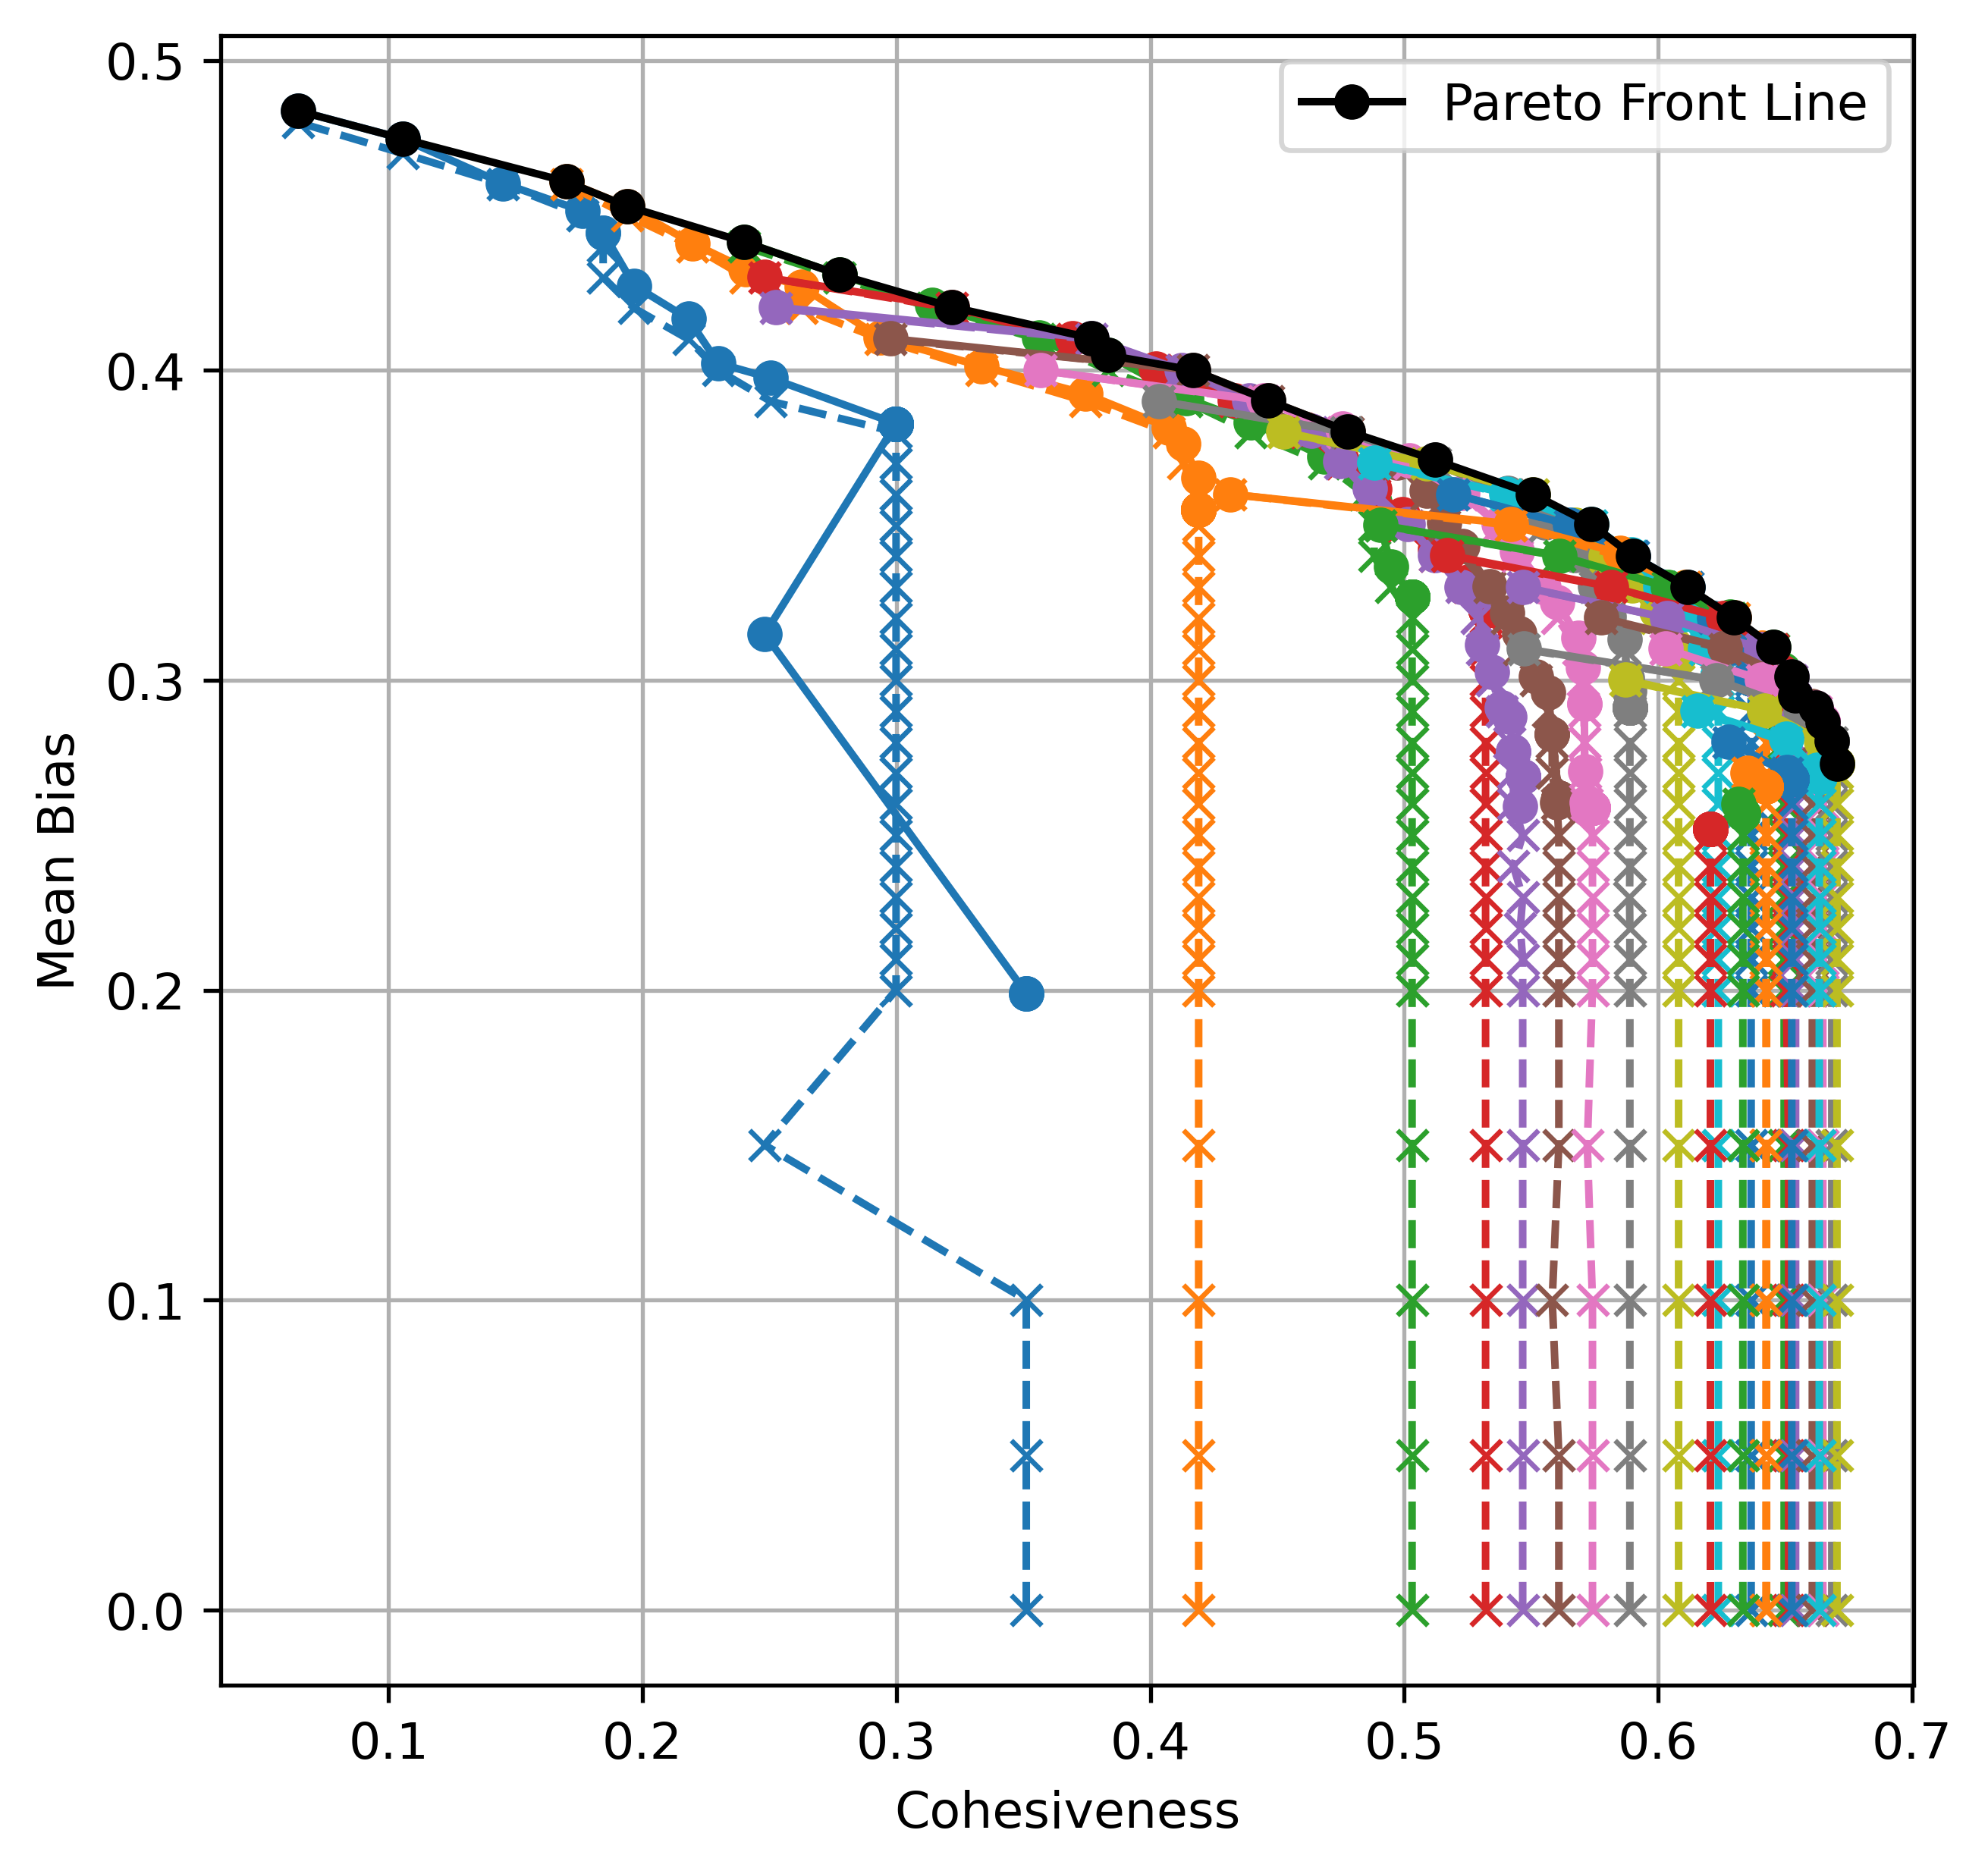

In [17]:
for i in range(1):
    ASD_Cont_Paretos[i].plotFront()

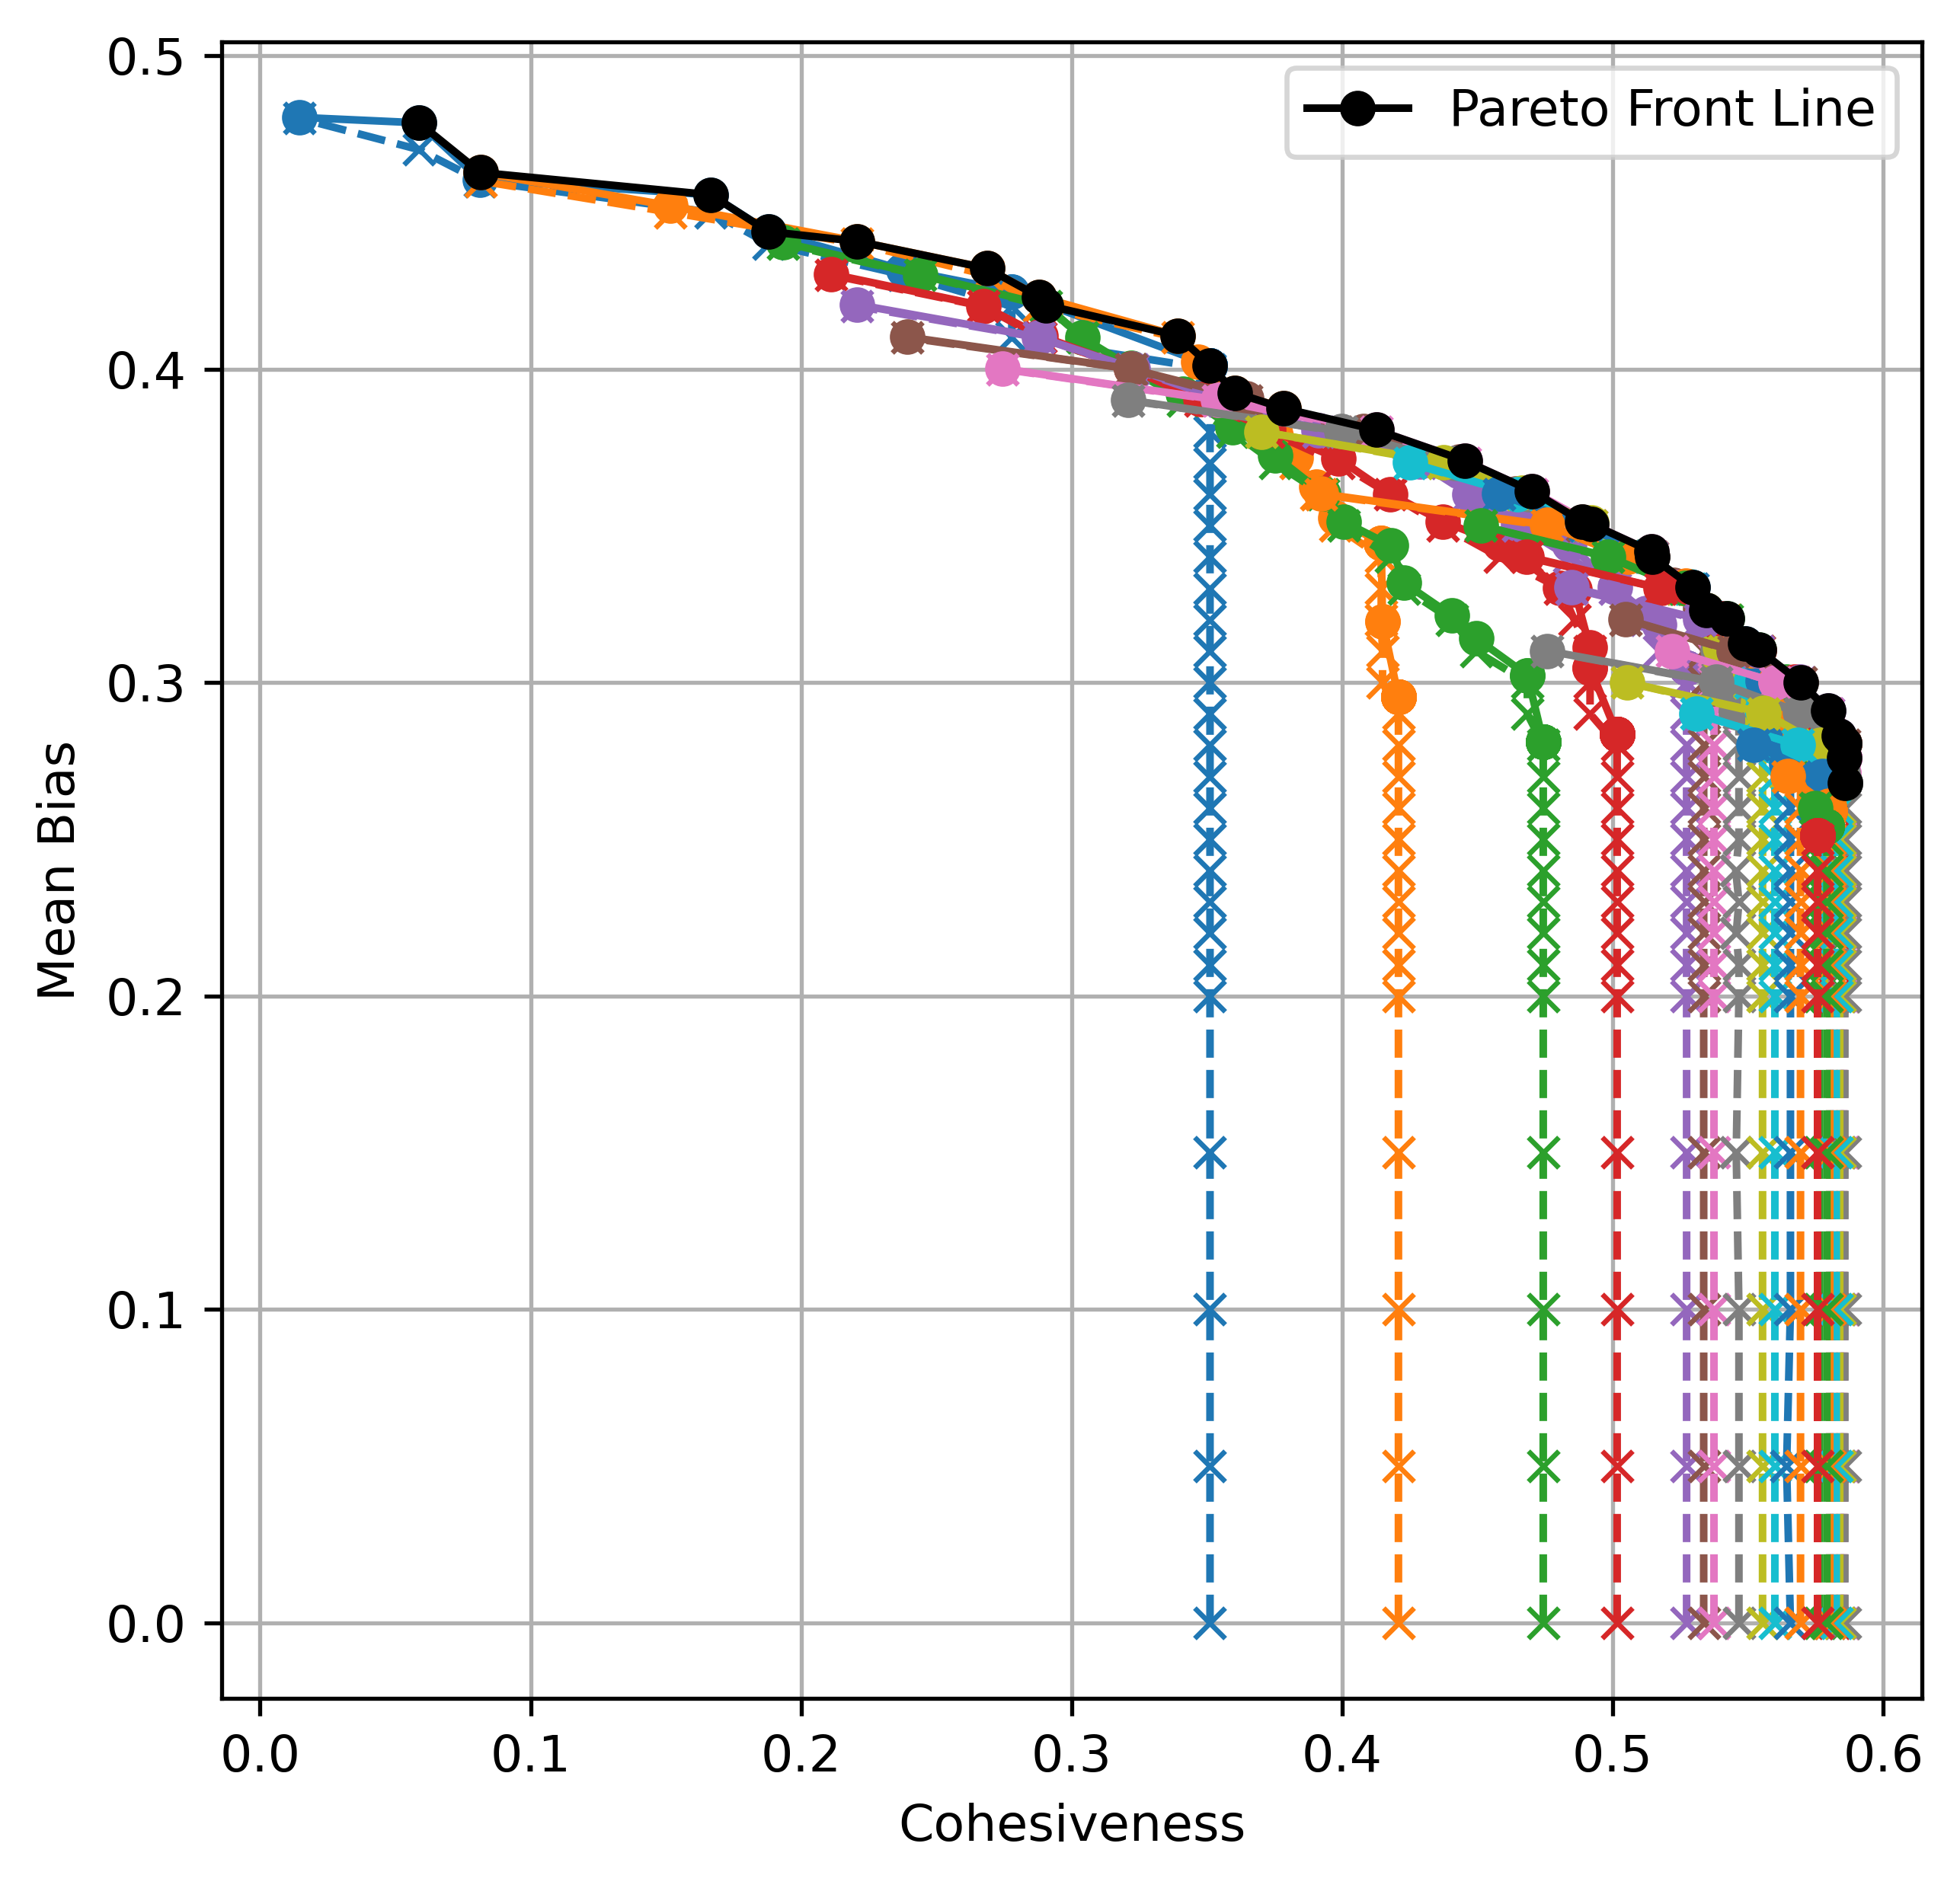

In [18]:
ASD_Cont_Paretos[3].plotFront()

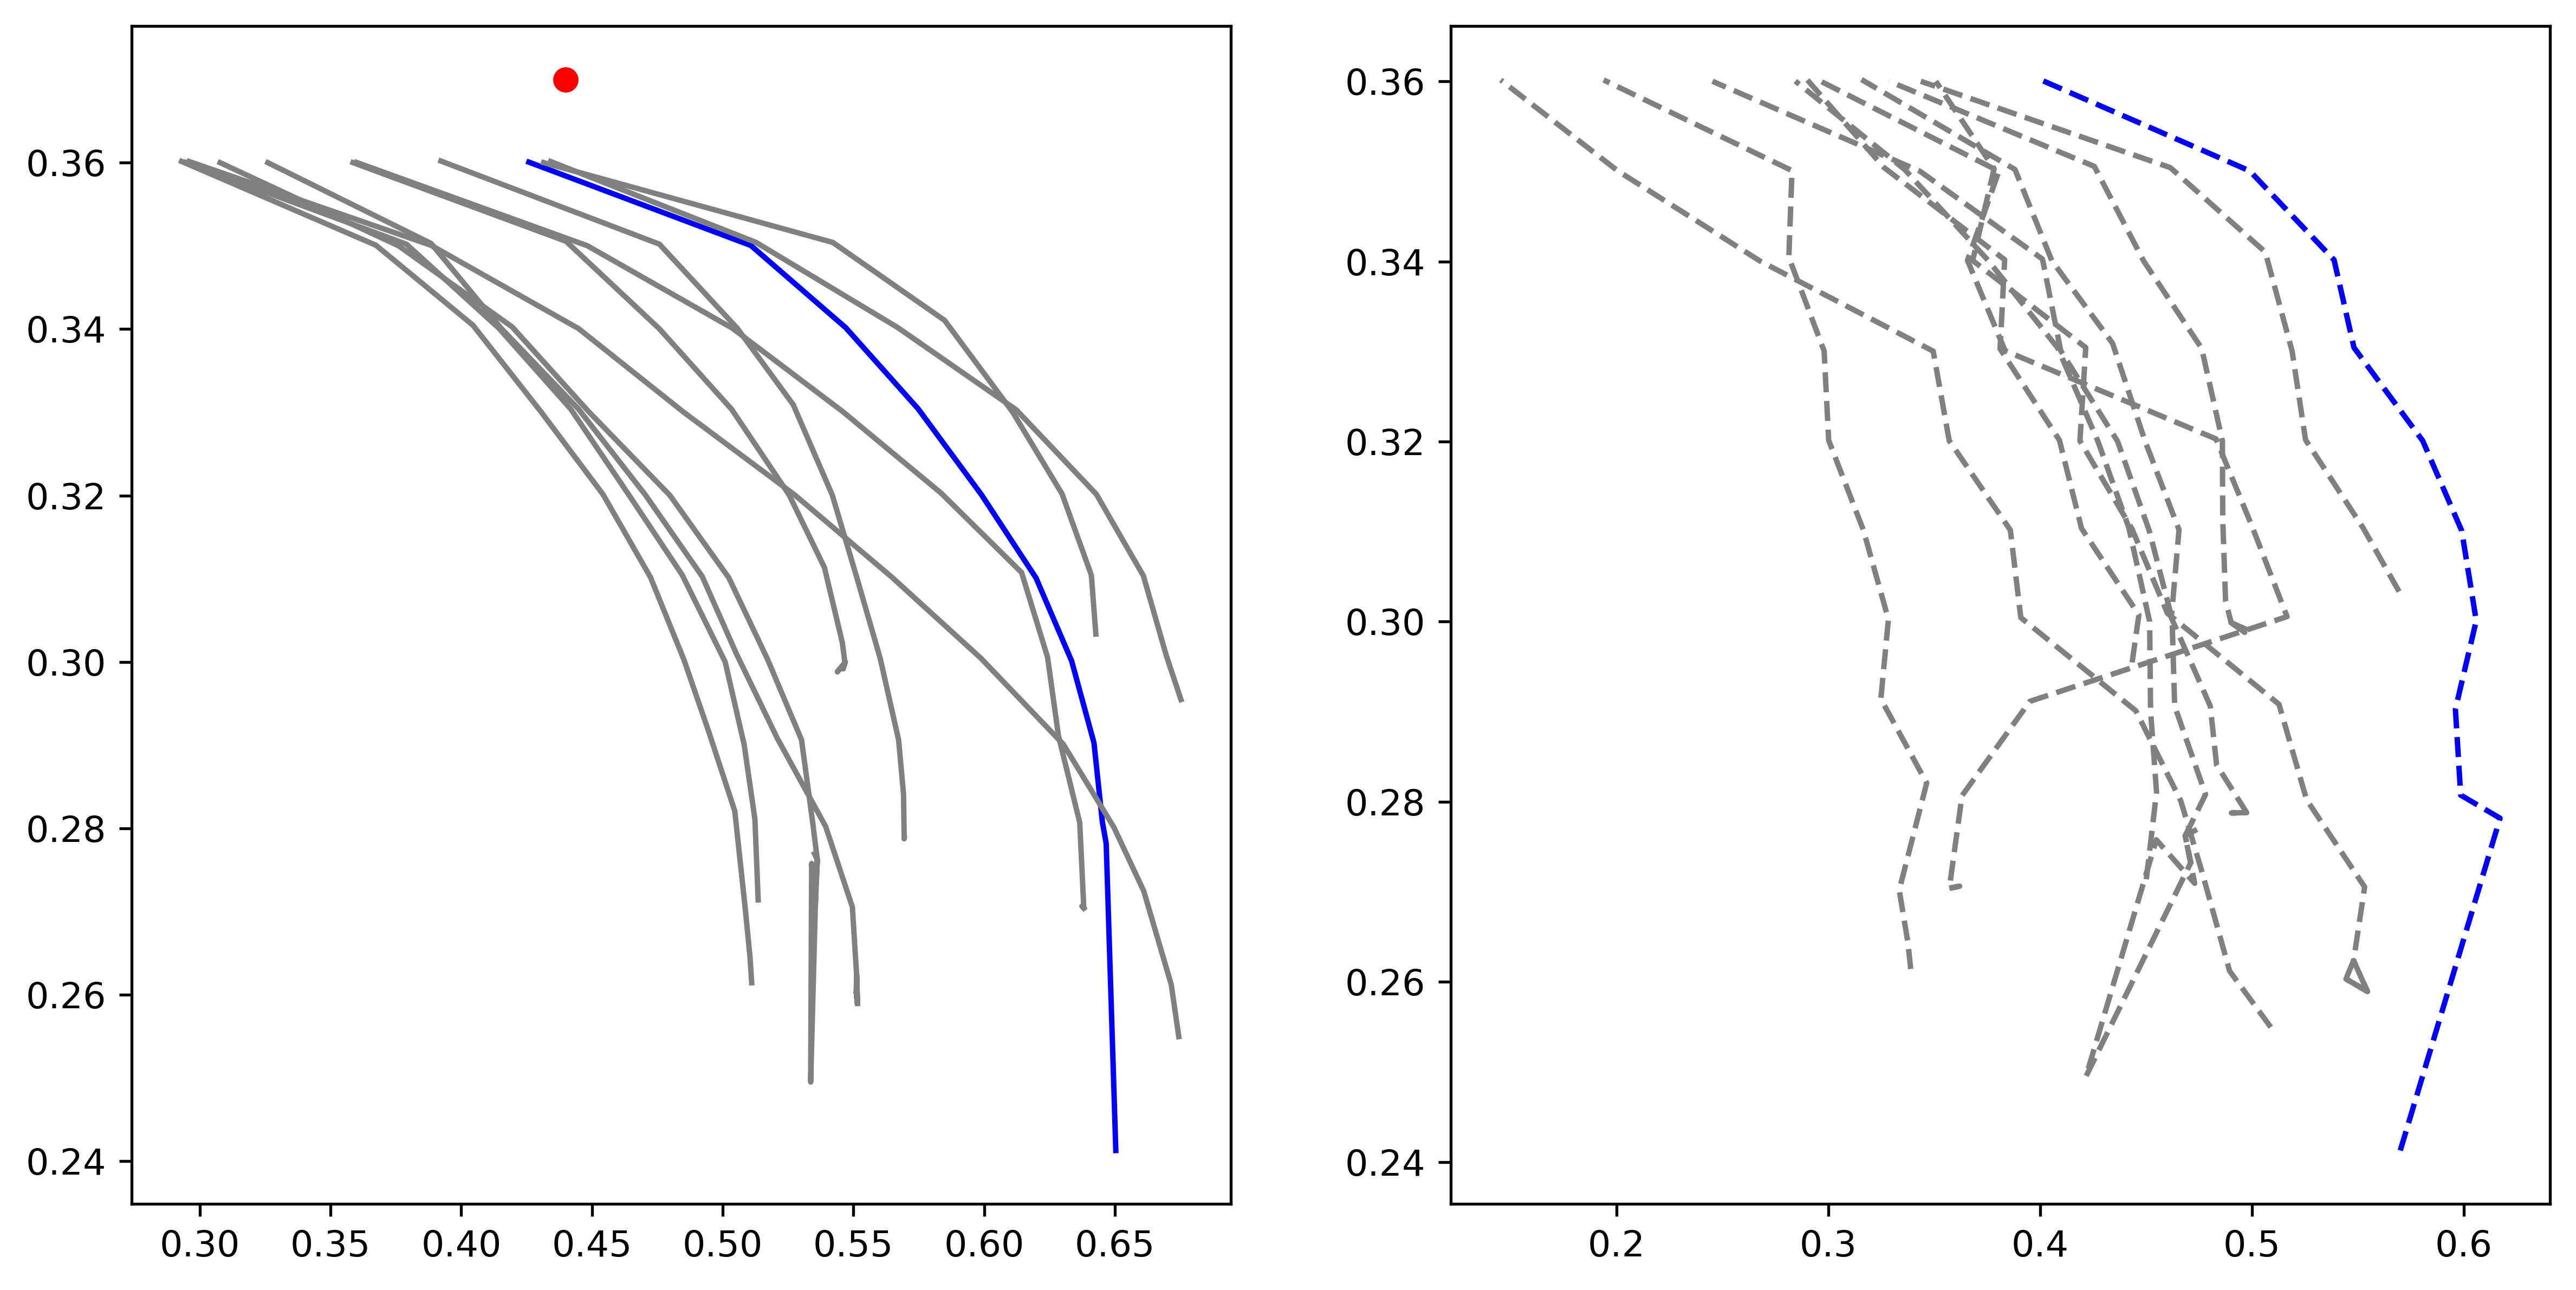

In [21]:
size = 60
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=480, figsize=(12,6))

xx = ASD_Pareto.DF[ASD_Pareto.DF["Size"]==size]
bias = xx["Bias"]
cohe = xx["Cohe"]
ax1.plot(cohe, bias, color="blue", label="ASD")
ax1.scatter(0.44, 0.37, color="red")
cohe = xx["Cohe_Distal"]
ax2.plot(cohe, bias, color="blue", ls="--", label="ASD Distal")
#print(bias, cohe)
#print()
for i in range(1, 11, 1):
    xx = ASD_Cont_Paretos[i-1]
    xx = xx.DF[xx.DF["Size"]==size]
    bias = xx["Bias"]
    cohe = xx["Cohe"]
    ax1.plot(cohe, bias, color="grey")
    cohe = xx["Cohe_Distal"]
    ax2.plot(cohe, bias, color="grey", ls="--")
#    bias = xx["Bias"].mean()
#    cohe = xx["Cohe_Distal"].mean()
#    print(bias, cohe)

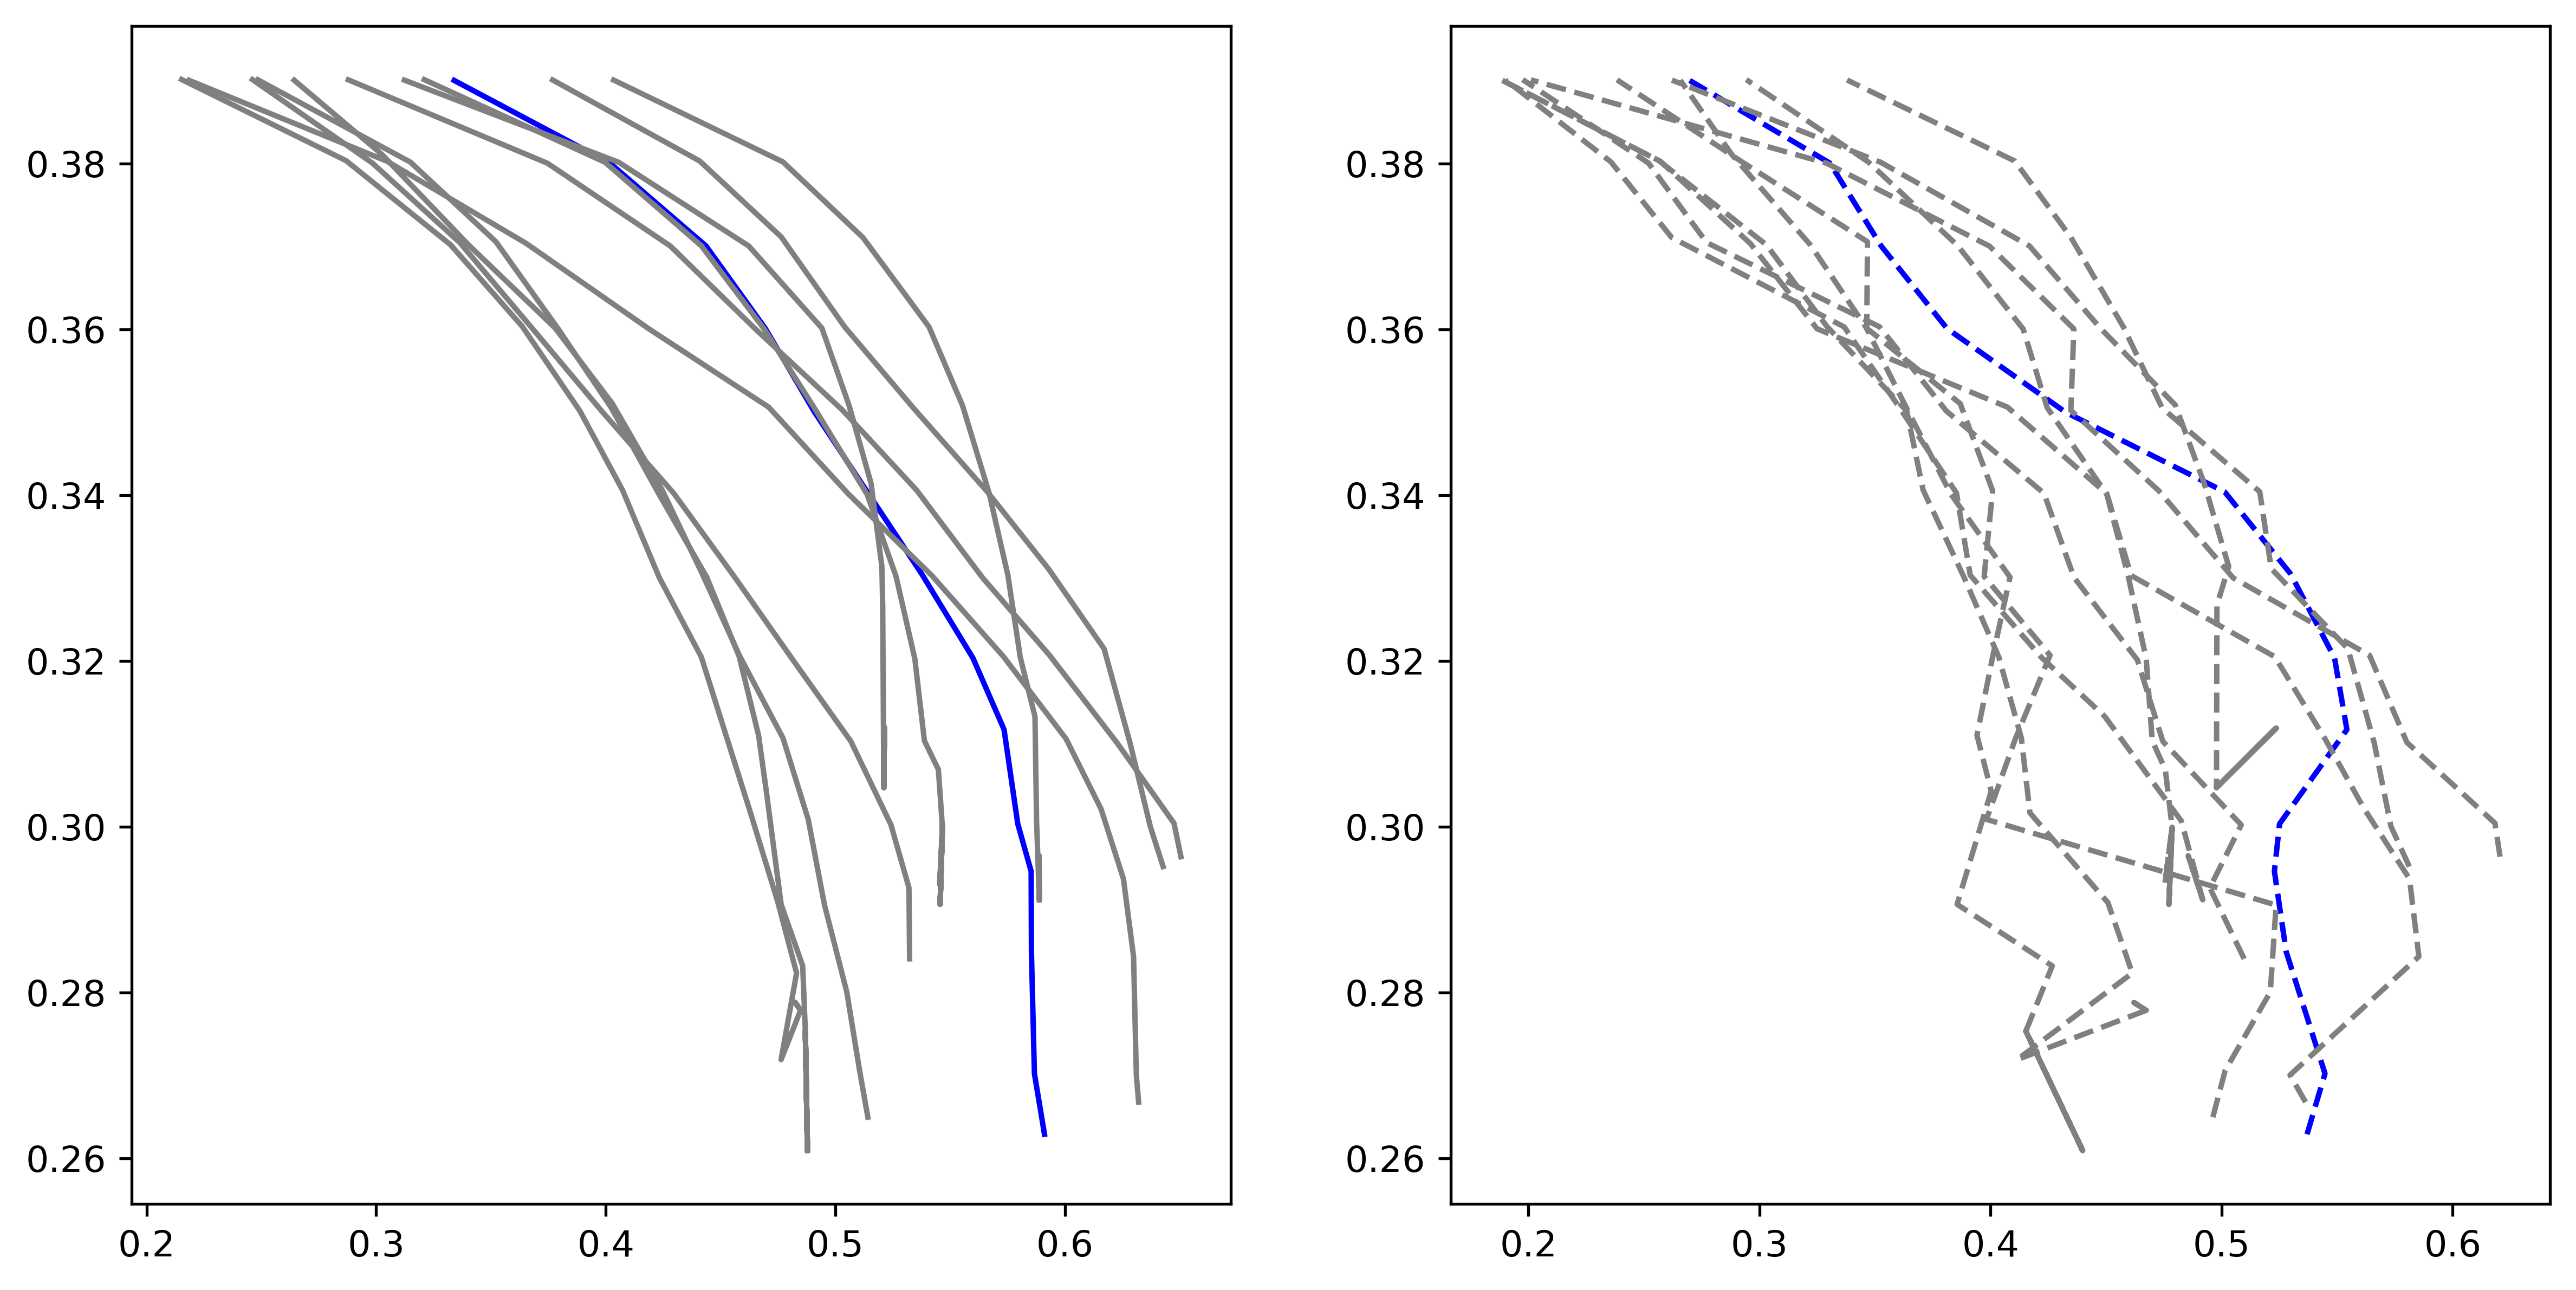

In [20]:
#size = 50
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=480, figsize=(12,6))
xx = ASD_Pareto.DF[ASD_Pareto.DF["Size"]==size]
bias = xx["Bias"]
cohe = xx["Cohe"]
ax1.plot(cohe, bias, color="blue", label="ASD")
cohe = xx["Cohe_CR"]
ax2.plot(cohe, bias, color="blue", ls="--", label="ASD Distal")
#print(bias, cohe)
#print()
for i in range(1, 11, 1):
    xx = ASD_Cont_Paretos[i-1]
    xx = xx.DF[xx.DF["Size"]==size]
    bias = xx["Bias"]
    cohe = xx["Cohe"]
    ax1.plot(cohe, bias, color="grey")
    cohe = xx["Cohe_CR"]
    ax2.plot(cohe, bias, color="grey", ls="--")
plt.show()